In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Inventory_DataSet/train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
train.shape

(913000, 4)

In [ ]:
# per 1 store, 1 item
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
# train_df = train_df.set_index('date')
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df.shape

<ipython-input-5-c5e5a58c0623>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[train['item']==1]


(1826, 8)

In [ ]:
pf=train_df.copy()

<Axes: >

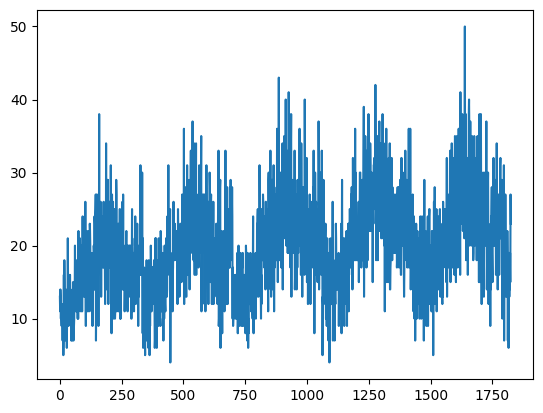

In [ ]:
train_df['sales'].plot()

In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

Defining Function for ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.01:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
train['sales'].shape

(913000,)

In [ ]:
adf_test(train_df['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.157671
p-value                    0.022569
# lags used               23.000000
# observations          1802.000000
critical value (1%)       -3.433984
critical value (5%)       -2.863145
critical value (10%)      -2.567625
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


the smaller p-value, the more likely it's stationary. Here our p-value is 0.036. It's actually not bad, if we use a 5% Critical Value(CV), this series would be considered stationary. But as we just visually found an upward trend, we want to be more strict, we use 1% CV.
To get a stationary data, there's many techiniques. We can use log, differencing etc...

#Making the data stationary

Different techniques can be used to make the data stationary.
Here we have used second difference to detrend data

In [ ]:
train_df[19:]['sales'].head()

19    15
20     8
21     7
22     9
23     8
Name: sales, dtype: int64

In [ ]:
df_testing = pd.DataFrame(train_df.sales.diff().diff(12))

In [ ]:
df_testing.head()

,sales
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


<Axes: >

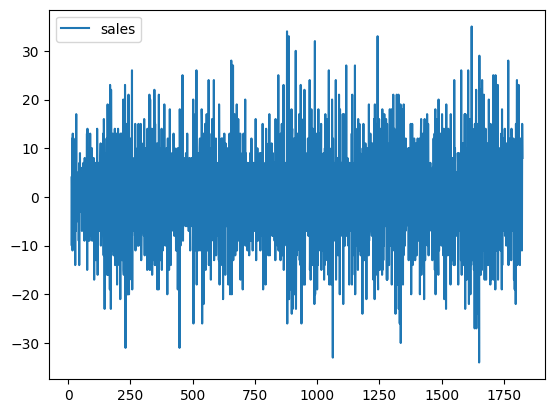

In [ ]:
df_testing.dropna()
df_testing.plot()

In [ ]:
adf_test(df_testing['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.380602e+01
p-value                 8.399456e-26
# lags used             2.500000e+01
# observations          1.787000e+03
critical value (1%)    -3.434015e+00
critical value (5%)    -2.863159e+00
critical value (10%)   -2.567632e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


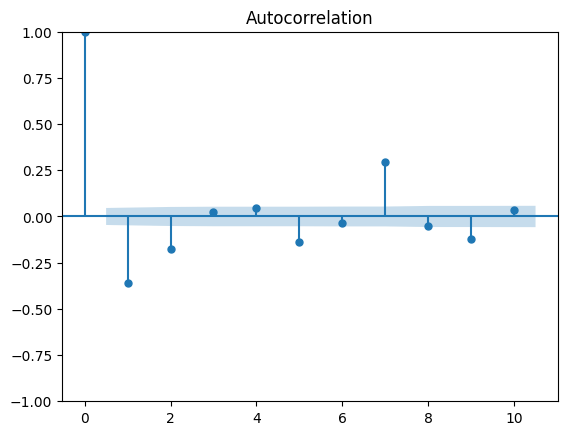

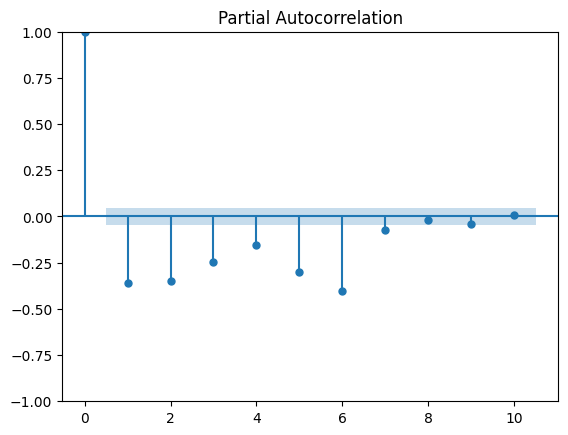

In [ ]:
ACF = plot_acf(df_testing.dropna(),lags=10)
PACF = plot_pacf(df_testing.dropna(),lags=10)

#Fitting AR Model

Defined AR function

In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['sales'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['sales','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['sales','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['sales'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

From the PACF plot, we can see significant spikes at lags 1 to 6 because of the significant PACF value. In contrast, for everything within the blue band, we don’t have evidence that it’s different from zero.

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,7):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.sales))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i

print(best_p)

The RMSE is : 10.616522996664385 , Value of p :  1
The RMSE is : 9.903133827551965 , Value of p :  2
The RMSE is : 9.55379067364196 , Value of p :  3
The RMSE is : 9.505588746595041 , Value of p :  4
The RMSE is : 9.013771037721718 , Value of p :  5
The RMSE is : 8.08933414744015 , Value of p :  6
6


In [ ]:
[df_train,df_test,theta_AR,intercept_AR,RMSE] = AR(6,pd.DataFrame(df_testing.sales))

The RMSE is : 8.08933414744015 , Value of p :  6


<Axes: >

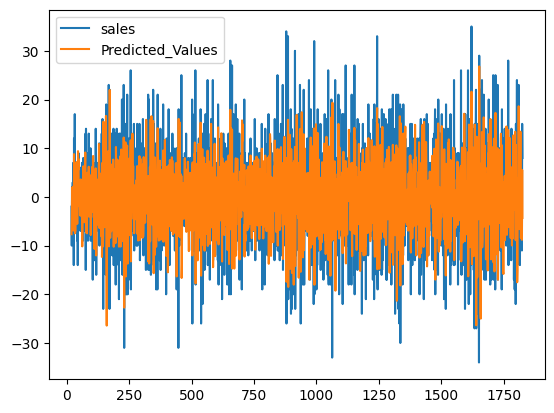

In [ ]:
df_c = pd.concat([df_train,df_test])
#plt.figure(figsize=(15,10))
df_c[['sales','Predicted_Values']].plot()

Generating the residuals for MA

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.sales - df_c.Predicted_Values
res.head()

,Residuals
19,5.662002
20,-4.019275
21,2.853004
22,0.713000
23,-1.051230


#Fitting MA on Residuals

Defined MA function

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



From the ACF plot, we analyzed all spikes higher than the blue area, i.e. q=7 and q=1

The RMSE is : 8.060239637469726 , Value of q :  7
The RMSE is : 8.115420041851564 , Value of q :  1


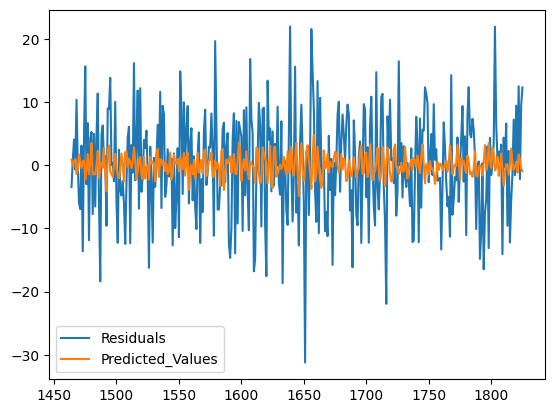

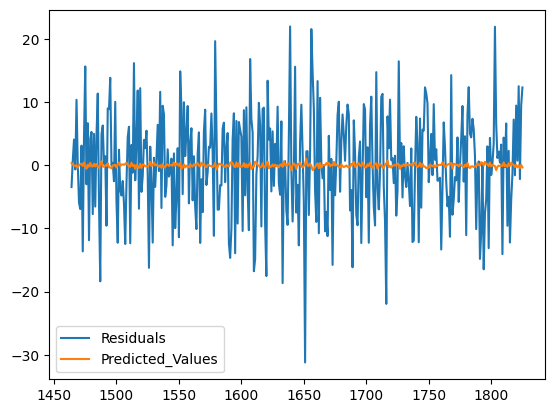

In [ ]:
best_RMSE=100000000000
best_q = -1
[res_train,res_test,theta,intercept,RMSE] = MA(7,pd.DataFrame(res.Residuals))
[res_train,res_test,theta,intercept,RMSE] = MA(1,pd.DataFrame(res.Residuals))

The RMSE is : 8.060239637469726 , Value of q :  7
[[-0.0344243]]
[-0.01207113]


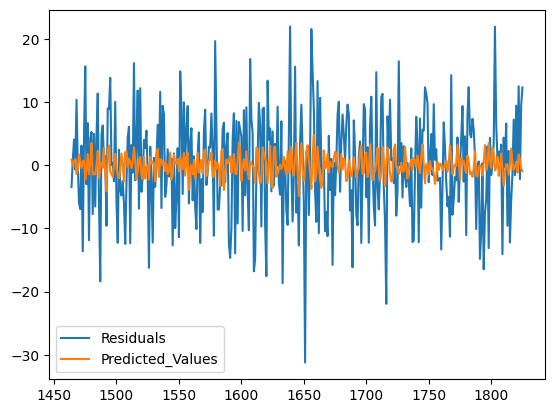

In [ ]:
[res_train,res_test,theta_MA,intercept_MA,RMSE] = MA(7,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [ ]:
res_c = pd.concat([res_train,res_test])
res_c.head()

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
26,5.339908,-4.631447,4.648391,-1.051230,0.713000,2.853004,-4.019275,5.662002,-0.356900
27,3.908440,5.339908,-4.631447,4.648391,-1.051230,0.713000,2.853004,-4.019275,0.330593
28,-10.507585,3.908440,5.339908,-4.631447,4.648391,-1.051230,0.713000,2.853004,-0.746965
29,3.211534,-10.507585,3.908440,5.339908,-4.631447,4.648391,-1.051230,0.713000,0.694235
30,-7.505612,3.211534,-10.507585,3.908440,5.339908,-4.631447,4.648391,-1.051230,-0.863657


<Axes: >

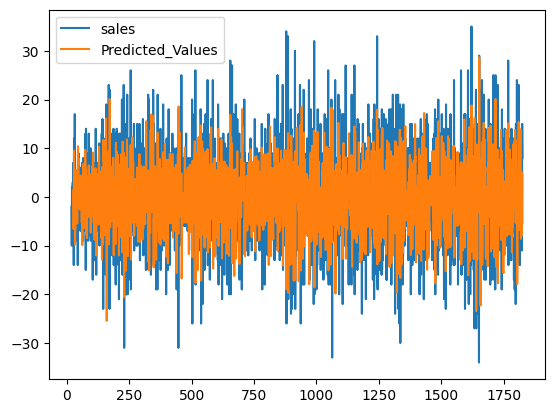

In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values
df_c[['sales','Predicted_Values']].plot()

In [ ]:
df_c.head()

,sales,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Predicted_Values
19,-2.0,13.0,-11.0,12.0,3.0,-10.0,4.0,NaN
20,-10.0,-2.0,13.0,-11.0,12.0,3.0,-10.0,NaN
21,2.0,-10.0,-2.0,13.0,-11.0,12.0,3.0,NaN
22,2.0,2.0,-10.0,-2.0,13.0,-11.0,12.0,NaN
23,1.0,2.0,2.0,-10.0,-2.0,13.0,-11.0,NaN


<h1>
Calculating the Final Residuals. after applying ARIMA
</h1>

<ipython-input-31-8d3495e782d3>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


Text(0.5, 1.0, 'Residual distribution')

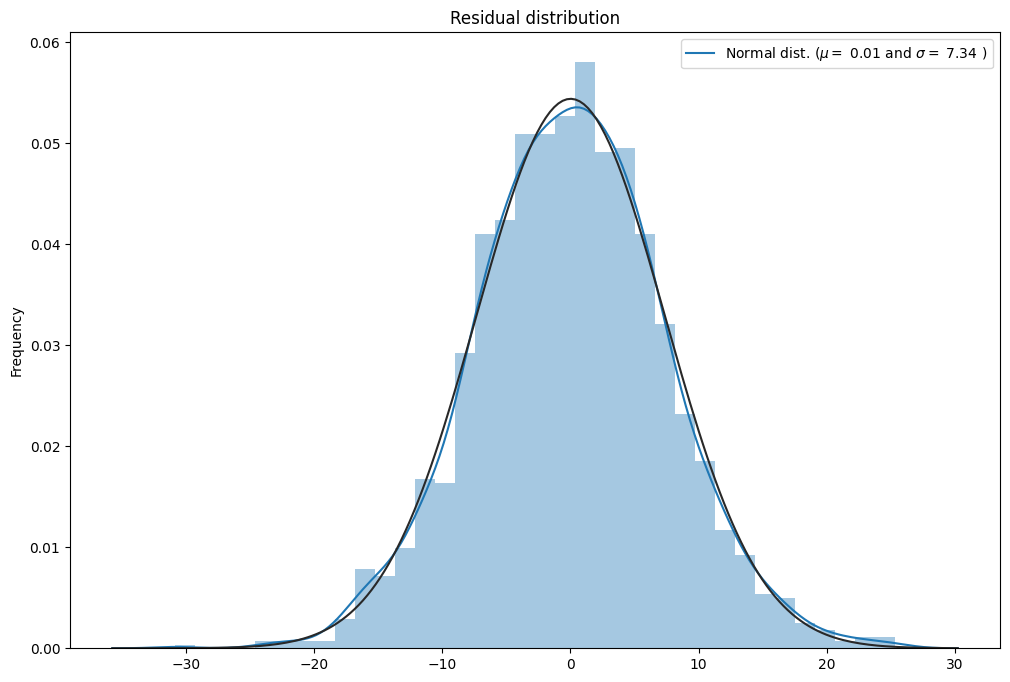

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid= df_c.sales - df_c.Predicted_Values

resid.dropna(inplace=True)

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')



/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


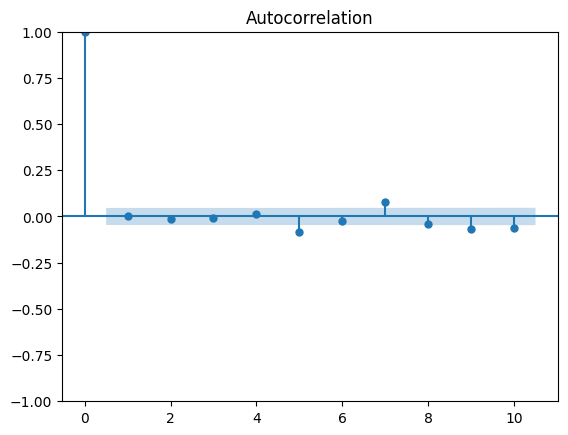

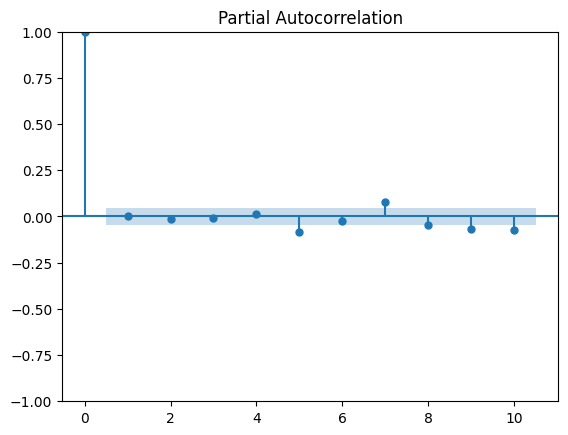

In [ ]:

ACF = plot_acf(resid.dropna(),lags=10)
PACF = plot_pacf(resid.dropna(),lags=10)

In [ ]:
df_c.drop(df_c.columns[1:7],axis=1,inplace=True)
df_k=df_c.copy()
df_k.head()

,sales,Predicted_Values
19,-2.0,NaN
20,-10.0,NaN
21,2.0,NaN
22,2.0,NaN
23,1.0,NaN


#Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [ ]:
df_c.sales += train_df.sales.shift(1)
df_c.sales += train_df.sales.diff().shift(12)
df_c.Predicted_Values += train_df.sales.shift(1)
df_c.Predicted_Values += train_df.sales.diff().shift(12)
df_c.Value = df_c.sales
df_c.Predicted_Values = df_c.Predicted_Values

<ipython-input-34-dac2a0c7b147>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_c.Value = df_c.sales


In [ ]:
df_k=df_c.copy()

<Axes: >

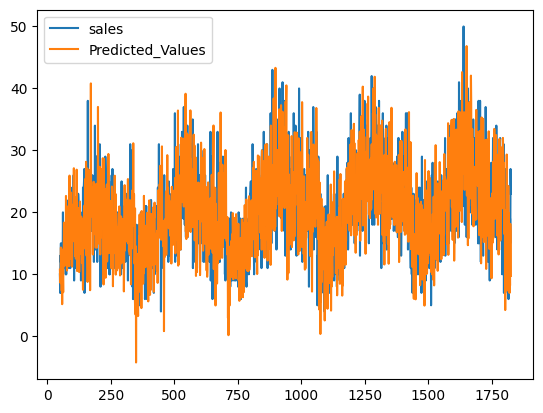

In [ ]:
df_c.iloc[30:,:][['sales','Predicted_Values']].plot()



<Axes: >

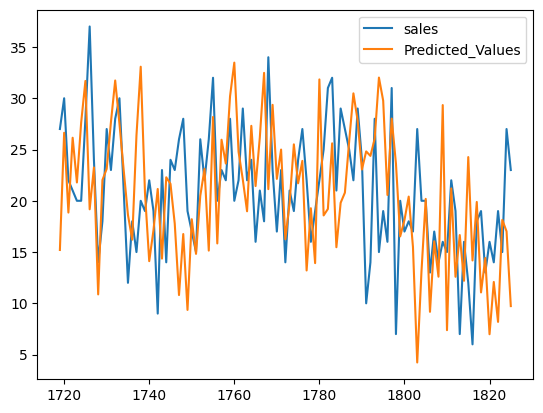

In [ ]:
df_c.iloc[1700:,:][['sales','Predicted_Values']].plot()

In [ ]:
df_k.sales.values[-12]

16.0

In [ ]:
df_testing[1820:]

,sales
1820,6.0
1821,-4.0
1822,6.0
1823,-11.0
1824,15.0
1825,8.0


# future prediction

In [ ]:

future_pred=(df_testing[1820:].sales.values).dot(theta_AR) + intercept_AR    +(df_testing[1819:].sales.values).dot(theta_MA) + intercept_MA
ans=future_pred+df_k.sales.values[-1]+df_k.sales.values[-12]
df_k.loc[len(df_k.index)+19] = [ans[0], ans[0]]





future_pred_2=(np.append(df_testing[1821:].sales.values,(future_pred))).dot(theta_AR) + intercept_AR    +(np.append(df_testing[1820:].sales.values,(future_pred))).dot(theta_MA) + intercept_MA
ans=future_pred+df_k.sales.values[-1]+df_k.sales.values[-12]
df_k.loc[len(df_k.index)+19] = [ans[0],ans[0]]



future_pred_3=(np.concatenate((df_testing[1822:].sales.values,(future_pred),(future_pred_2)), axis=None)).dot(theta_AR) + intercept_AR    +(np.concatenate((df_testing[1821:].sales.values,(future_pred),(future_pred_2)), axis=None)).dot(theta_MA) + intercept_MA
ans=future_pred+df_k.sales.values[-1]+df_k.sales.values[-12]
df_k.loc[len(df_k.index)+19] = [ans[0], ans[0]]



<Axes: >

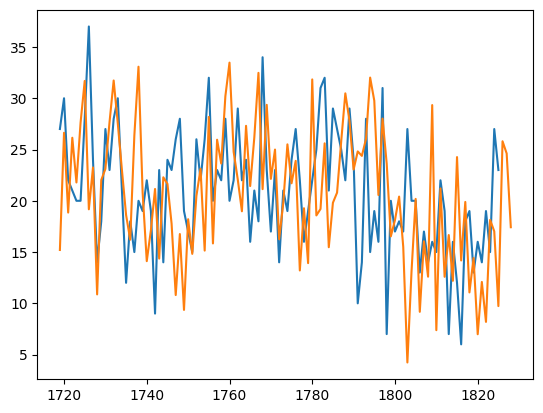

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

df_c.iloc[1700:,:]['sales'].plot()
df_k.iloc[1700:,:]['Predicted_Values'].plot()

<Axes: >

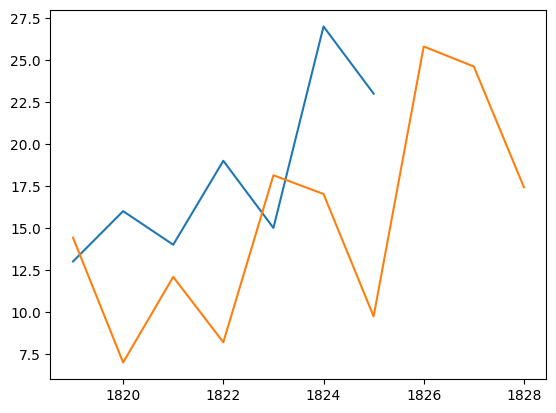

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

df_c.iloc[1800:,:]['sales'].plot()
df_k.iloc[1800:,:]['Predicted_Values'].plot()